In [59]:
import pandas as pd 
Calidad_de_agua_2022 = pd.read_csv('Calidad_de_agua_2022.csv',delimiter = ';')
Calidad_de_agua_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   orden                    168 non-null    int64 
 1   sitios                   168 non-null    object
 2   codigo                   168 non-null    object
 3   fecha                    168 non-null    object
 4   año                      168 non-null    object
 5   campaña                  168 non-null    object
 6   tem_agua                 168 non-null    object
 7   tem_aire                 166 non-null    object
 8   od                       168 non-null    object
 9   ph                       168 non-null    object
 10  olores                   168 non-null    object
 11  color                    168 non-null    object
 12  espumas                  168 non-null    object
 13  mat_susp                 168 non-null    object
 14  colif_fecales_ufc_100ml  167 non-null    o

In [60]:
aguadataframe = Calidad_de_agua_2022.copy()

In [61]:
aguadataframe = aguadataframe.drop(columns='orden')
aguadataframe = aguadataframe.drop(columns='año')
aguadataframe = aguadataframe.drop(columns='fecha')
aguadataframe = aguadataframe.drop(columns='cd_total_mg_l')
aguadataframe = aguadataframe.drop(columns='calidad_de_agua')
aguadataframe = aguadataframe.drop(columns='hidr_deriv_petr_ug_l')
aguadataframe = aguadataframe.drop(columns='codigo')
aguadataframe = aguadataframe.drop(columns='sitios')

In [62]:
aguadataframe = aguadataframe.replace({"no se midió": pd.NA,
                                         "no midieron este día": pd.NA,
                                         "no se determinó": pd.NA,
                                         "no midio la sonda": pd.NA})
aguadataframe = aguadataframe.dropna(thresh=15)

In [63]:
columnas_numericas=['tem_agua', 'tem_aire', 'od', 'ph','turbiedad_ntu','ica']
aguadataframe[columnas_numericas]=aguadataframe[columnas_numericas].replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')


In [64]:
boolean_columns = ['espumas', 'olores', 'color', 'mat_susp']
for col in boolean_columns:
    aguadataframe[col] = aguadataframe[col].replace({'Presencia': True,
                                                       'Ausencia': False,
                                                       'ausencia': False,
                                                       'Ausente': False,
                                                       }).astype(bool)

C:\Users\court\AppData\Local\Temp\ipykernel_11304\4201531465.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aguadataframe[col] = aguadataframe[col].replace({'Presencia': True,
C:\Users\court\AppData\Local\Temp\ipykernel_11304\4201531465.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aguadataframe[col] = aguadataframe[col].replace({'Presencia': True,
C:\Users\court\AppData\Local\Temp\ipykernel_11304\4201531465.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To 

In [65]:
for col in ['cr_total_mg_l', 'clorofila_a_ug_l', 'microcistina_ug_l','nitrato_mg_l','nh4_mg_l','p_total_l_mg_l',
            'fosf_ortofos_mg_l','dbo_mg_l','dqo_mg_l','enteroc_ufc_100ml','escher_coli_ufc_100ml','colif_fecales_ufc_100ml']:  # Ajustá con el nombre de tus columnas
    aguadataframe[col] = aguadataframe[col].str.replace(r'^\s*<\s*', '', regex=True)  # Elimina "<" o " <" al inicio
    aguadataframe[col] = pd.to_numeric(aguadataframe[col], errors='coerce')  # Convierte a numérico

In [66]:
aguadataframe = pd.get_dummies(aguadataframe, columns=['campaña'])

In [67]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
columnas_numericas = aguadataframe.select_dtypes(include='number')
aguadataframe[columnas_numericas.columns] = imputer.fit_transform(columnas_numericas).round(3)

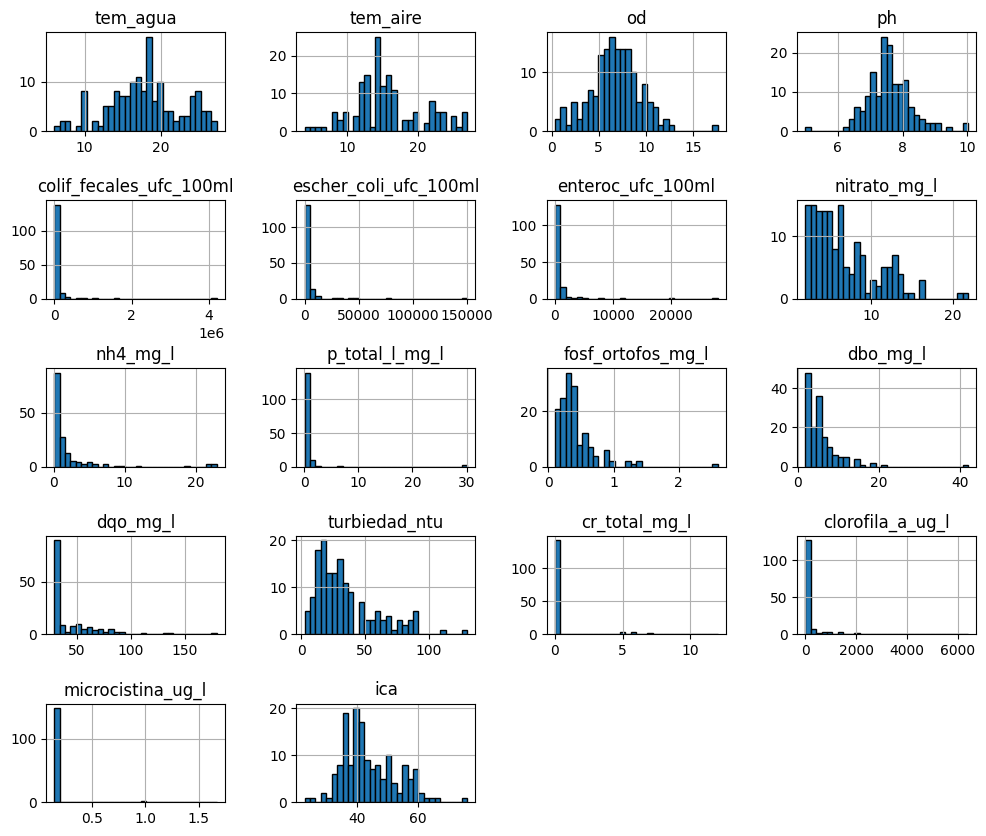

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
aguadataframe.hist(figsize=(12,10),bins=30,edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

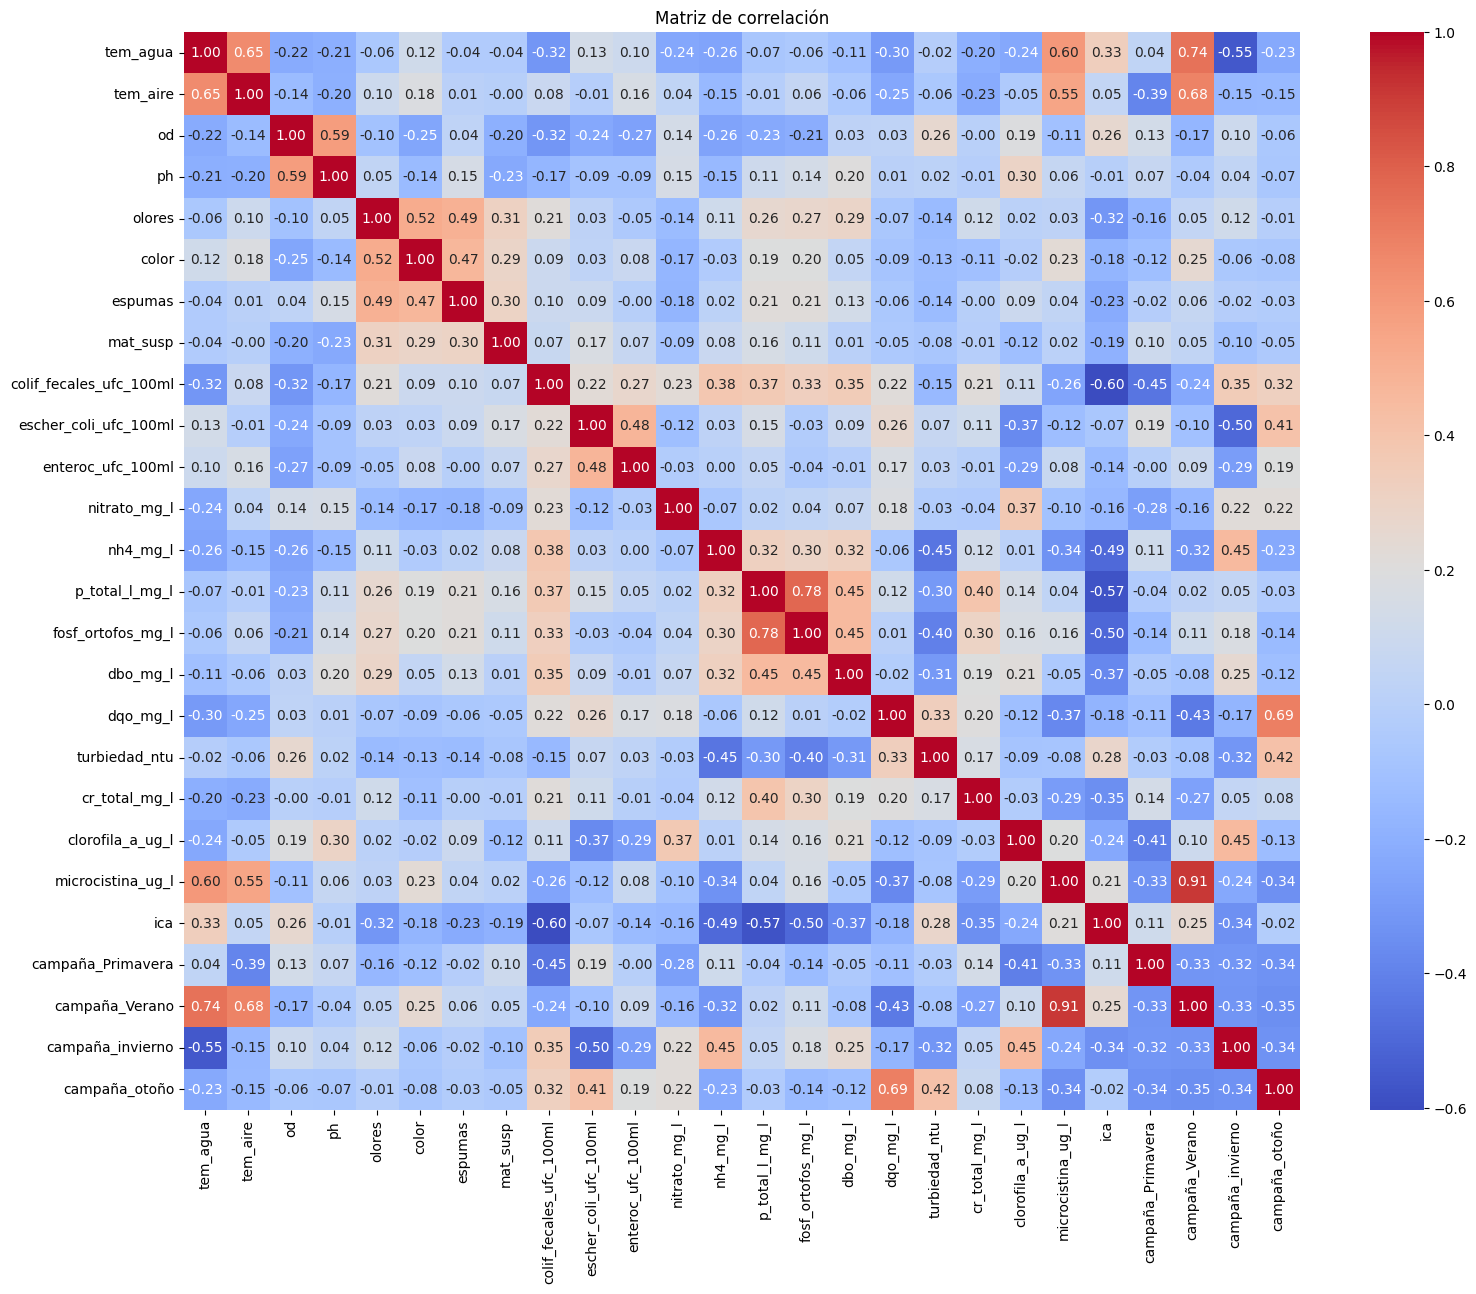

In [ ]:
import seaborn as sns

plt.figure(figsize=(18,14))
sns.heatmap(aguadataframe.corr(method='spearman'), annot=True, cmap='coolwarm', fmt='.2f') #spearman es mejor con muchos outlier y poca normalidad 
plt.title('Matriz de correlación')
plt.show()

Hipótesis 1: La calidad del agua se ve afectada por la presencia de bacterias fecales

C:\Users\court\AppData\Local\Temp\ipykernel_11304\3000608172.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlaciones_ordenadas.values, y=correlaciones_ordenadas.index, palette=colores)


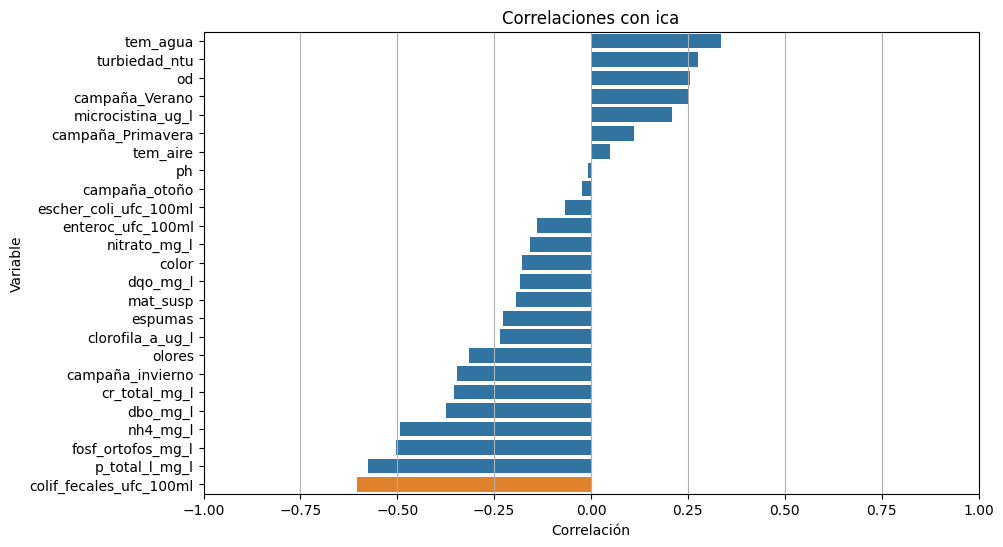

In [71]:
ica_correlaciones = aguadataframe.corr(method='spearman')['ica'].drop('ica')
correlaciones_ordenadas = ica_correlaciones.sort_values(ascending=False)

colores = ['#1f77b4' if variable != 'colif_fecales_ufc_100ml' else '#ff7f0e' for variable in correlaciones_ordenadas.index]

plt.figure(figsize=(10,6))
plt.grid(True)
sns.barplot(x=correlaciones_ordenadas.values, y=correlaciones_ordenadas.index, palette=colores)
plt.title('Correlaciones con ica')
plt.xlabel('Correlación')
plt.ylabel('Variable')
plt.xlim([-1,1])
plt.show()

In [72]:
umbral = aguadataframe['colif_fecales_ufc_100ml'].median()
grupo_bajo = aguadataframe[aguadataframe['colif_fecales_ufc_100ml'] < umbral]
grupo_alto = aguadataframe[aguadataframe['colif_fecales_ufc_100ml'] >= umbral]

In [73]:
from scipy.stats import shapiro

stat, p = shapiro(grupo_bajo['ica'])
print(f"Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(grupo_alto['ica'])
print(f"Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico=0.954, p-valor=0.007
Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico=0.936, p-valor=0.001


In [74]:
from scipy.stats import levene

stat, p = levene(grupo_bajo['ica'], grupo_alto['ica'])
print(f"Test de Levene para ica en ambos grupos: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Levene para ica en ambos grupos: Estadístico=10.641, p-valor=0.001


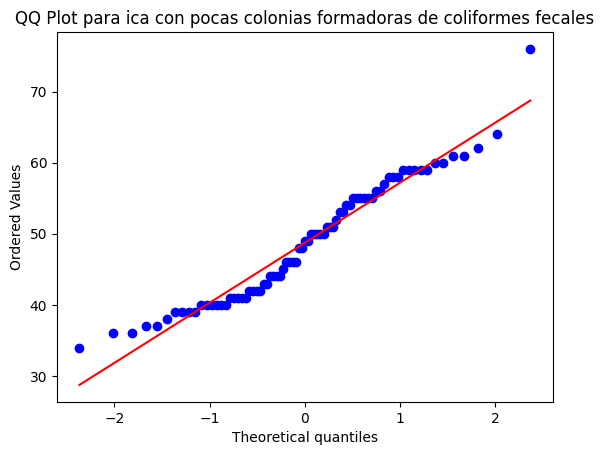

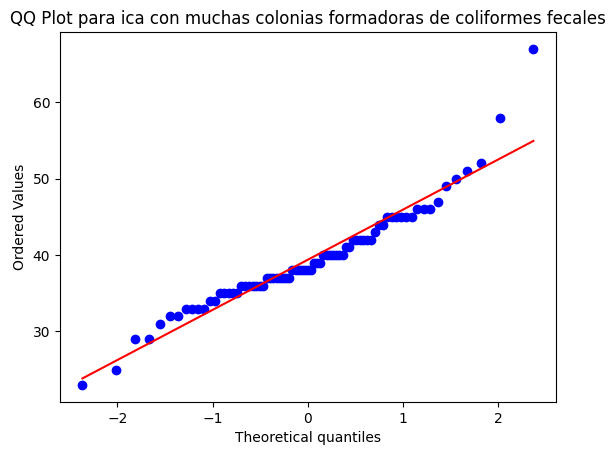

In [75]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(grupo_bajo['ica'], dist="norm", plot=plt)
plt.title("QQ Plot para ica con pocas colonias formadoras de coliformes fecales")
plt.show()

stats.probplot(grupo_alto['ica'], dist="norm", plot=plt)
plt.title("QQ Plot para ica con muchas colonias formadoras de coliformes fecales")
plt.show()

como los datos no son homocedasticos  nos vamos a hacer el test de kruskal

In [76]:
# Test de Kruskal-Wallis para comparar muestras de agua con alta concentracion de coliferos y bajos 
stat, p = stats.kruskal(grupo_bajo['ica'],grupo_alto['ica'])
print(f"Test de Kruskal-Wallis para grupos_colif Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay diferencia entre los grupos")
else:
    print("Se rechaza la hipótesis nula.")
    print("Existe una diferencia significativa ")

Test de Kruskal-Wallis para grupos_colif Estadístico=45.127, p-valor=0.000
Se rechaza la hipótesis nula.
Existe una diferencia significativa 


C:\Users\court\AppData\Local\Temp\ipykernel_11304\1841599090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo_bajo['concentracion_coliformes'] = 'Baja'
C:\Users\court\AppData\Local\Temp\ipykernel_11304\1841599090.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo_alto['concentracion_coliformes'] = 'Alta'


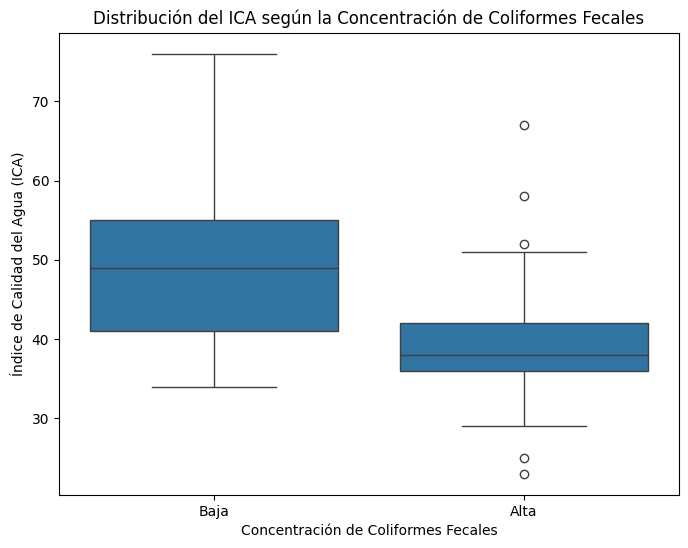

In [77]:
# Crear una nueva columna que indique el grupo (alta o baja concentración)
grupo_bajo['concentracion_coliformes'] = 'Baja'
grupo_alto['concentracion_coliformes'] = 'Alta'

# Concatenar los dos grupos en un solo DataFrame para facilitar el graficado
df_concentracion = pd.concat([grupo_bajo, grupo_alto])

# Crear el boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_concentracion, x='concentracion_coliformes', y='ica')
plt.title('Distribución del ICA según la Concentración de Coliformes Fecales')
plt.xlabel('Concentración de Coliformes Fecales')
plt.ylabel('Índice de Calidad del Agua (ICA)')
plt.show()

Hipótesis 2: La concentración de bacterias fecales varía según la estación del año

In [78]:
primavera = aguadataframe[aguadataframe['campaña_Primavera'] == True]
verano = aguadataframe[aguadataframe['campaña_Verano'] == True]
invierno = aguadataframe[aguadataframe['campaña_invierno'] == True]
otoño = aguadataframe[aguadataframe['campaña_otoño'] == True]

In [79]:
stat, p = shapiro(primavera['colif_fecales_ufc_100ml'])
print(f"Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(verano['colif_fecales_ufc_100ml'])
print(f"Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(invierno['colif_fecales_ufc_100ml'])
print(f"Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(otoño['colif_fecales_ufc_100ml'])
print(f"Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico=0.315, p-valor=0.000
Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico=0.260, p-valor=0.000
Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico=0.389, p-valor=0.000
Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico=0.701, p-valor=0.000


In [80]:
# Aplicar el test de Levene para comparar las varianzas entre las estaciones
stat, p = levene(primavera['colif_fecales_ufc_100ml'], 
                 verano['colif_fecales_ufc_100ml'], 
                 invierno['colif_fecales_ufc_100ml'], 
                 otoño['colif_fecales_ufc_100ml'])

# Mostrar el resultado
print(f"Test de Levene para homocedasticidad en colif_fecales_ufc_100ml entre estaciones: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Levene para homocedasticidad en colif_fecales_ufc_100ml entre estaciones: Estadístico=4.016, p-valor=0.009


vamos a realizar el test de kruskal nuevamente ya que tampoco los datos son homocedasticos 

In [81]:
from scipy.stats import kruskal

# Aplicar el test de Kruskal-Wallis
stat, p = kruskal(primavera['colif_fecales_ufc_100ml'], 
                  verano['colif_fecales_ufc_100ml'], 
                  invierno['colif_fecales_ufc_100ml'], 
                  otoño['colif_fecales_ufc_100ml'])

# Mostrar el resultado
print(f"Test de Kruskal-Wallis para concentraciones de coliformes fecales entre estaciones: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación del resultado
if p > alpha:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay diferencias significativas en las concentraciones de bacterias fecales entre las estaciones.")
else:
    print("Se rechaza la hipótesis nula.")
    print("Existen diferencias significativas en las concentraciones de bacterias fecales entre las estaciones.")


Test de Kruskal-Wallis para concentraciones de coliformes fecales entre estaciones: Estadístico=55.719, p-valor=0.000
Se rechaza la hipótesis nula.
Existen diferencias significativas en las concentraciones de bacterias fecales entre las estaciones.


Hipótesis 2: La concentración de bacterias fecales varía según la estación del año

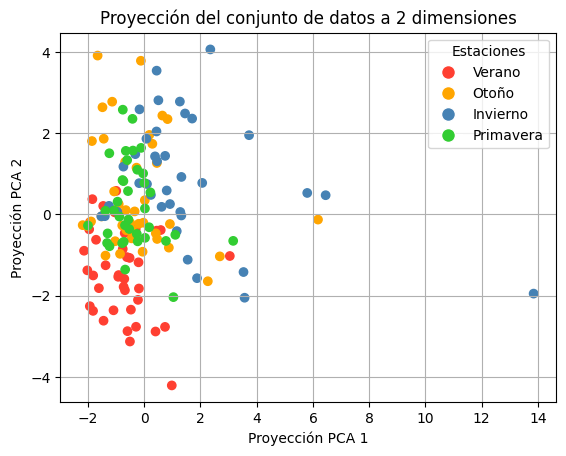

In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

# Seleccionamos las columnas numéricas
x = aguadataframe.select_dtypes(include='number')

# Escalamos los datos
scaler = StandardScaler()
x_escalada = scaler.fit_transform(x)

# Realizamos PCA con 2 componentes
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_escalada)

# Crear una nueva columna 'estacion' que combine las 4 columnas booleanas
estaciones = []
for _, row in aguadataframe.iterrows():
    if row['campaña_Verano']:
        estaciones.append('Verano')
    elif row['campaña_otoño']:
        estaciones.append('Otoño')
    elif row['campaña_invierno']:
        estaciones.append('Invierno')
    elif row['campaña_Primavera']:
        estaciones.append('Primavera')

# Convertimos las estaciones a una serie de pandas
estaciones = pd.Series(estaciones)

# Colores personalizados para cada estación con tonos agradables
color_map = {
    'Verano': '#FF3F31',
    'Primavera': '#32CD32',
    'Invierno': '#4682B4',
    'Otoño': '#FFA500'
}

# Asignamos los colores de acuerdo con la estación
colores = estaciones.map(color_map)

# Crear el gráfico
fig, ax = plt.subplots()

# Crear los puntos en el gráfico, asignando el color según la estación
scatter = ax.scatter(x_pca[:, 0], x_pca[:, 1], c=colores)

# Etiquetas y título
ax.grid(True)
ax.set_xlabel('Proyección PCA 1')
ax.set_ylabel('Proyección PCA 2')
ax.set_title('Proyección del conjunto de datos a 2 dimensiones')

# Crear una leyenda manual con los colores y las estaciones
handles = []
labels = ['Verano', 'Otoño', 'Invierno', 'Primavera']

# Agregar un marcador para cada estación
for label in labels:
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[label], markersize=10)
    handles.append(handle)

# Agregar la leyenda al gráfico
ax.legend(handles=handles, labels=labels, title="Estaciones")

# Mostrar el gráfico
plt.show()


Before t-SNE: (154, 18)
After t-SNE: (154, 2)


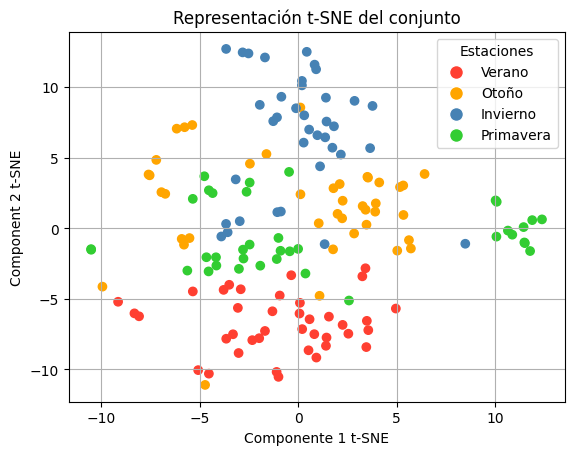

In [83]:
from sklearn.manifold import TSNE

# creamos el objeto, lo fitteamos en nuestros datos y lo aplicamos sobre esos mismos
#X_tsne = TSNE(n_components=2).fit_transform(X_train_stand) # sin random state
X_tsne = TSNE(n_components=2, random_state=10).fit_transform(x_escalada)  # con random state
# imprimimos los tamaños antes y después
print('Before t-SNE: {}'.format(x_escalada.shape))
print('After t-SNE: {}'.format(X_tsne.shape))

# graficamos los datos, el color de cada punto representa el valor de la casa
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colores, label=estaciones)
plt.grid(True)
plt.xlabel('Componente 1 t-SNE')
plt.ylabel('Component 2 t-SNE')
plt.title('Representación t-SNE del conjunto')
plt.legend(handles=handles, labels=labels, title="Estaciones")
plt.show()

c:\Users\court\OneDrive\Documentos\FundamentosDatos\TPE\PracticoEspecialGrupo14\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Antes de UMAP: (154, 18)
Después de UMAP: (154, 2)


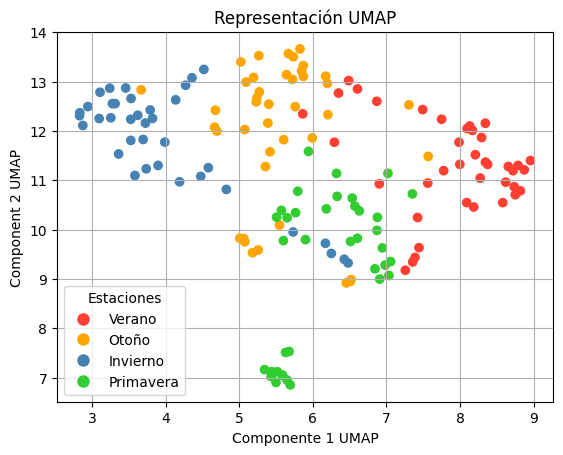

In [84]:
import umap.umap_ as umap

# creamos el objeto, lo fitteamos en nuestros datos y lo aplicamos sobre esos mismos
X_umap = umap.UMAP(n_components=2, random_state=20).fit_transform(x_escalada)
# imprimimos los tamaños antes y después
print('Antes de UMAP: {}'.format(x_escalada.shape))
print('Después de UMAP: {}'.format(X_umap.shape))

# graficamos los datos, el color de cada punto representa el valor de la casa
plt.scatter(X_umap[:,0], X_umap[:,1], c=colores, label=estaciones)
plt.grid(True)
plt.xlabel('Componente 1 UMAP')
plt.ylabel('Component 2 UMAP')
plt.title('Representación UMAP')
plt.legend(handles=handles, labels=labels, title="Estaciones")
plt.show()

C:\Users\court\AppData\Local\Temp\ipykernel_11304\544113088.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=aguadataframe, x='estacion', y='colif_fecales_ufc_100ml', palette="Set2")


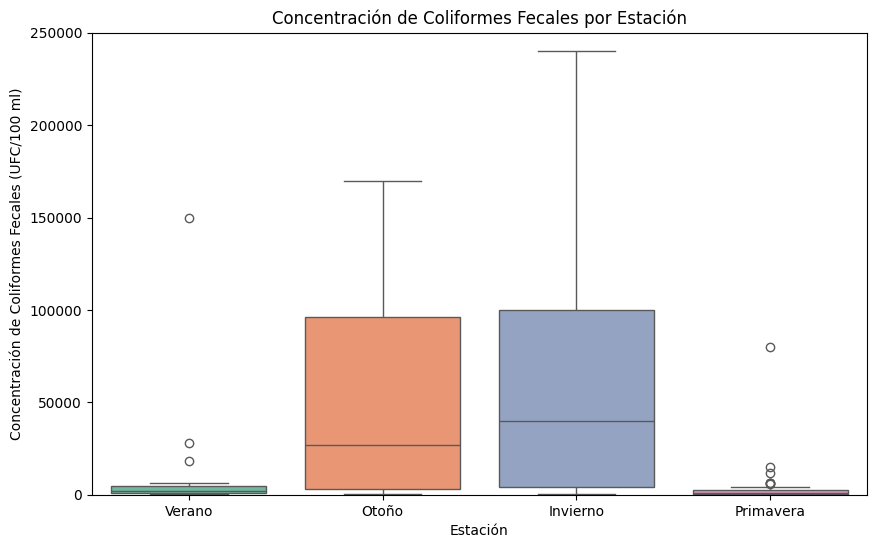

In [85]:
aguadataframe['estacion'] = None
aguadataframe.loc[aguadataframe['campaña_Primavera'] == True, 'estacion'] = 'Primavera'
aguadataframe.loc[aguadataframe['campaña_Verano'] == True, 'estacion'] = 'Verano'
aguadataframe.loc[aguadataframe['campaña_invierno'] == True, 'estacion'] = 'Invierno'
aguadataframe.loc[aguadataframe['campaña_otoño'] == True, 'estacion'] = 'Otoño'

# Graficar un boxplot para cada estación
plt.figure(figsize=(10, 6))
sns.boxplot(data=aguadataframe, x='estacion', y='colif_fecales_ufc_100ml', palette="Set2")
plt.title('Concentración de Coliformes Fecales por Estación')
plt.xlabel('Estación')
plt.ylabel('Concentración de Coliformes Fecales (UFC/100 ml)')
plt.ylim(0, 250000)  # Ajusta este rango según los valores que deseas visualizar
plt.show()

C:\Users\court\AppData\Local\Temp\ipykernel_11304\1916494773.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=median_values, y='estacion', x='colif_fecales_ufc_100ml', palette="coolwarm", ci=None)
C:\Users\court\AppData\Local\Temp\ipykernel_11304\1916494773.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=median_values, y='estacion', x='colif_fecales_ufc_100ml', palette="coolwarm", ci=None)


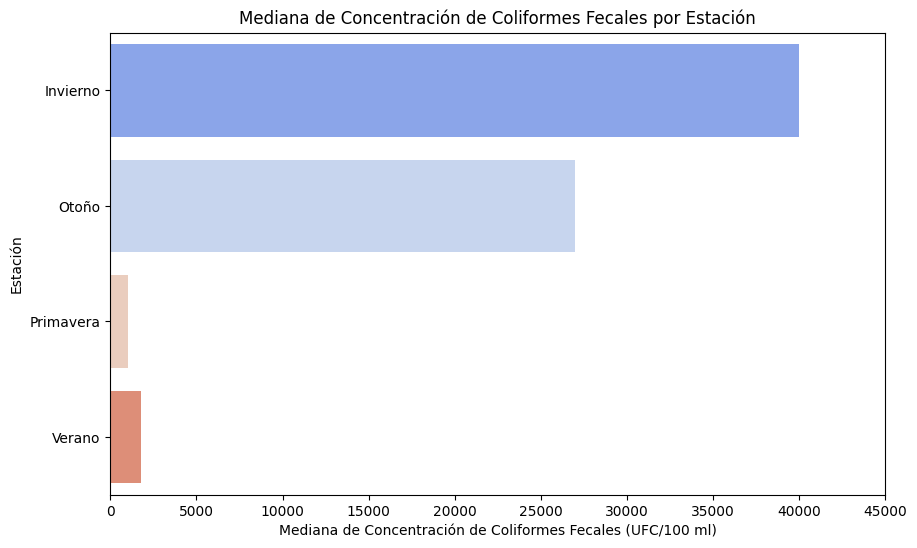

In [86]:
# Calcular la mediana de coliformes fecales por estación
median_values = aguadataframe.groupby('estacion')['colif_fecales_ufc_100ml'].median().reset_index()

# Crear un gráfico de barras horizontal con las medianas
plt.figure(figsize=(10, 6))
sns.barplot(data=median_values, y='estacion', x='colif_fecales_ufc_100ml', palette="coolwarm", ci=None)
plt.title('Mediana de Concentración de Coliformes Fecales por Estación')
plt.ylabel('Estación')
plt.xlabel('Mediana de Concentración de Coliformes Fecales (UFC/100 ml)')
plt.xlim(0, 45000)  # Ajusta este rango según los valores que deseas visualizar
plt.show()


Hipótesis 5: Las zonas con menor calidad de agua presentan mayor turbidez. 

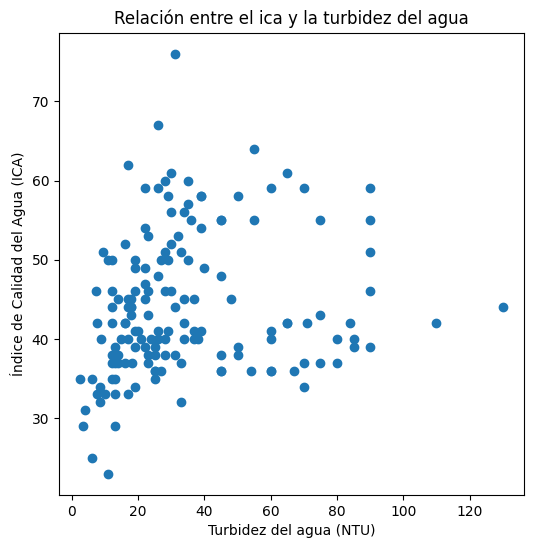

In [87]:
plt.figure(figsize=(6, 6))  # Hacer el gráfico cuadrado
plt.scatter(aguadataframe["turbiedad_ntu"], aguadataframe["ica"])

# Agregar etiquetas a los ejes
plt.xlabel("Turbidez del agua (NTU)")
plt.ylabel("Índice de Calidad del Agua (ICA)")

# Agregar un título al gráfico
plt.title("Relación entre el ica y la turbidez del agua")

# Mostrar el gráfico
plt.show()

In [88]:
# Definir el umbral de la mediana para la variable 'turbiedad_ntu'
umbral_median = aguadataframe['turbiedad_ntu'].median()

# Dividir en dos grupos: baja turbiedad (<= mediana) y alta turbiedad (> mediana)
grupo_bajo = aguadataframe[aguadataframe['turbiedad_ntu'] <= umbral_median]
grupo_alto = aguadataframe[aguadataframe['turbiedad_ntu'] > umbral_median]

In [89]:
stat, p = shapiro(grupo_bajo['ica'])
print(f"Test de Shapiro-Wilk para: Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(grupo_alto['ica'])
print(f"Test de Shapiro-Wilk para : Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Shapiro-Wilk para: Estadístico=0.970, p-valor=0.067
Test de Shapiro-Wilk para : Estadístico=0.927, p-valor=0.000


In [90]:
stat, p = levene(grupo_bajo['ica'], 
                 grupo_alto['ica'])

print(f"Test de Levene para homocedasticidad en ica entre grupos: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Levene para homocedasticidad en ica entre grupos: Estadístico=3.379, p-valor=0.068


In [91]:
from scipy.stats import mannwhitneyu
# Test de Mann-Whitney U para comparar los grupos en la variable 'ica'
stat, p = mannwhitneyu(grupo_bajo['ica'], grupo_alto['ica'])
print(f"Test de Mann-Whitney U (Baja vs Alta Turbiedad) en ICA: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay diferencia significativa en ICA entre los grupos de baja y alta turbiedad.")
else:
    print("Se rechaza la hipótesis nula.")
    print("Existe una diferencia significativa en ICA entre los grupos de baja y alta turbiedad.")

Test de Mann-Whitney U (Baja vs Alta Turbiedad) en ICA: Estadístico=2007.000, p-valor=0.001
Se rechaza la hipótesis nula.
Existe una diferencia significativa en ICA entre los grupos de baja y alta turbiedad.


C:\Users\court\AppData\Local\Temp\ipykernel_11304\1628164083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo_bajo['turbiedad_ntu'] = 'Baja'
C:\Users\court\AppData\Local\Temp\ipykernel_11304\1628164083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo_alto['turbiedad_ntu'] = 'Alta'


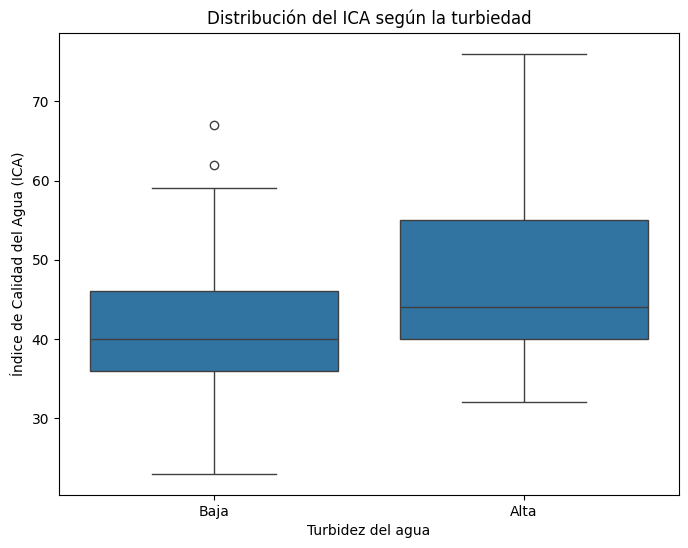

In [92]:
grupo_bajo['turbiedad_ntu'] = 'Baja'
grupo_alto['turbiedad_ntu'] = 'Alta'

# Concatenar los dos grupos en un solo DataFrame para facilitar el graficado
df_concentracion = pd.concat([grupo_bajo, grupo_alto])

# Crear el boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_concentracion, x='turbiedad_ntu', y='ica')
plt.title('Distribución del ICA según la turbiedad')
plt.xlabel('Turbidez del agua')
plt.ylabel('Índice de Calidad del Agua (ICA)')
plt.show()

Hipotesis: el fosforo total en el agua afecta el ica

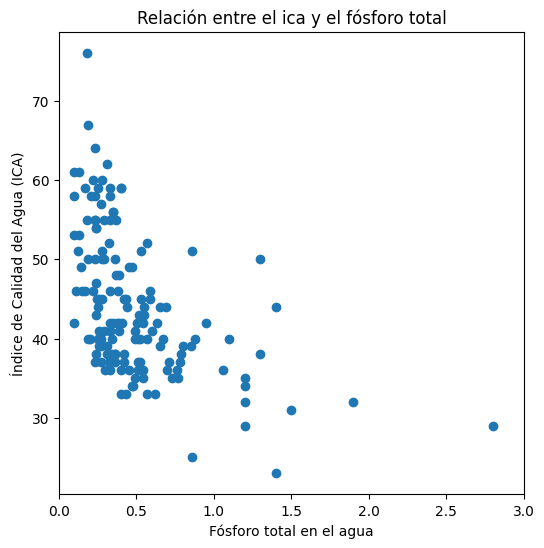

In [93]:
plt.figure(figsize=(6, 6))  # Hacer el gráfico cuadrado
plt.scatter(aguadataframe["p_total_l_mg_l"], aguadataframe["ica"])

# Agregar etiquetas a los ejes
plt.xlabel("Fósforo total en el agua")
plt.ylabel("Índice de Calidad del Agua (ICA)")

plt.xlim(0,3) #Limite que no incluye dos outliers

# Agregar un título al gráfico
plt.title("Relación entre el ica y el fósforo total")

# Mostrar el gráfico
plt.show()

In [94]:
umbral1 = aguadataframe['p_total_l_mg_l'].quantile(0.25)
umbral2 = aguadataframe['p_total_l_mg_l'].quantile(0.50)
umbral3 = aguadataframe['p_total_l_mg_l'].quantile(0.75)

# Filtrar los grupos según los umbrales definidos
grupo1 = aguadataframe[aguadataframe['p_total_l_mg_l'] <= umbral1]
grupo2 = aguadataframe[(aguadataframe['p_total_l_mg_l'] > umbral1) & (aguadataframe['p_total_l_mg_l'] <= umbral2)]
grupo3 = aguadataframe[(aguadataframe['p_total_l_mg_l'] > umbral2) & (aguadataframe['p_total_l_mg_l'] <= umbral3)]
grupo4 = aguadataframe[aguadataframe['p_total_l_mg_l'] > umbral3]

In [95]:
stat, p = shapiro(grupo1['ica'])
print(f"Test de Shapiro-Wilk para: Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(grupo2['ica'])
print(f"Test de Shapiro-Wilk para : Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(grupo3['ica'])
print(f"Test de Shapiro-Wilk para : Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(grupo4['ica'])
print(f"Test de Shapiro-Wilk para: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Shapiro-Wilk para: Estadístico=0.962, p-valor=0.207
Test de Shapiro-Wilk para : Estadístico=0.903, p-valor=0.003
Test de Shapiro-Wilk para : Estadístico=0.918, p-valor=0.008
Test de Shapiro-Wilk para: Estadístico=0.984, p-valor=0.850


In [96]:
stat, p = levene(grupo1['ica'], grupo2['ica'], grupo3['ica'], grupo4['ica'])
print(f"Test de Levene para homocedasticidad en ica entre grupos: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Levene para homocedasticidad en ica entre grupos: Estadístico=3.925, p-valor=0.010


In [97]:
from scipy.stats import median_test

stat, p_value, _, _ = median_test(grupo1['ica'], grupo2['ica'], grupo3['ica'], grupo4['ica'])

print(f'Valor p: {p_value:.3f}')

Valor p: 0.000


Esto indicaría evidencia suficiente para rechazar la hipótesis nula, respaldando la hipótesis alternativa de que el fósforo total en el agua afecta al ICA

C:\Users\court\AppData\Local\Temp\ipykernel_11304\2137630387.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Baja' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  grupo1.loc[:, 'p_total_l_mg_l'] = 'Baja'
C:\Users\court\AppData\Local\Temp\ipykernel_11304\2137630387.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Med-Baja' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  grupo2.loc[:, 'p_total_l_mg_l'] = 'Med-Baja'
C:\Users\court\AppData\Local\Temp\ipykernel_11304\2137630387.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Med-Alta' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  grupo3.loc[:, 'p_total_l_mg_l'] = 'Med-Alta'
C:\Users\court\

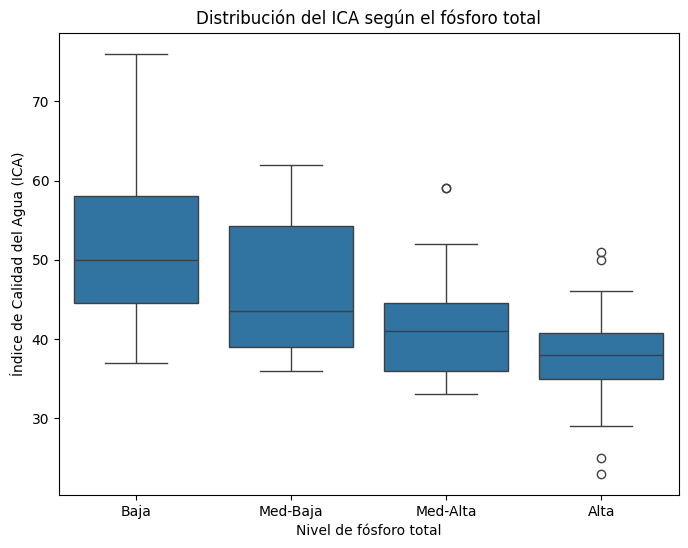

In [98]:
# Asegurarse de realizar la asignación utilizando .loc en cada grupo
grupo1.loc[:, 'p_total_l_mg_l'] = 'Baja'
grupo2.loc[:, 'p_total_l_mg_l'] = 'Med-Baja'
grupo3.loc[:, 'p_total_l_mg_l'] = 'Med-Alta'
grupo4.loc[:, 'p_total_l_mg_l'] = 'Alta'

# Concatenar los grupos en un solo DataFrame para facilitar el graficado
df_concentracion = pd.concat([grupo1, grupo2, grupo3, grupo4])

# Crear el boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_concentracion, x='p_total_l_mg_l', y='ica')
plt.title('Distribución del ICA según el fósforo total')
plt.xlabel('Nivel de fósforo total')
plt.ylabel('Índice de Calidad del Agua (ICA)')
plt.show()


hipotesis: El oxigeno disuelto en algua afecta el ica

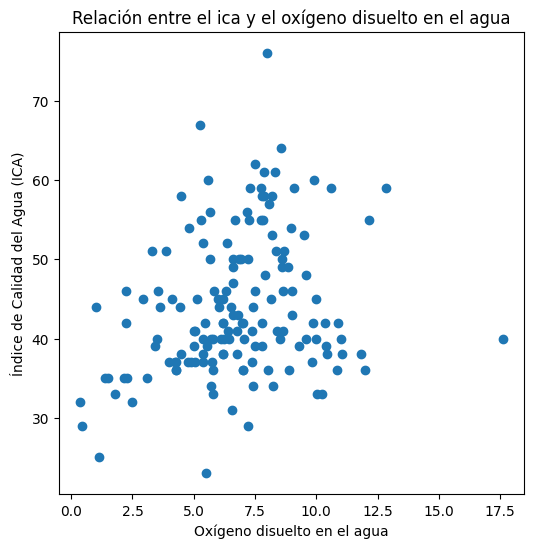

In [99]:
plt.figure(figsize=(6, 6))  # Hacer el gráfico cuadrado
plt.scatter(aguadataframe["od"], aguadataframe["ica"])

# Agregar etiquetas a los ejes
plt.xlabel("Oxígeno disuelto en el agua")
plt.ylabel("Índice de Calidad del Agua (ICA)")

# Agregar un título al gráfico
plt.title("Relación entre el ica y el oxígeno disuelto en el agua")

# Mostrar el gráfico
plt.show()

In [100]:
umbral1 = aguadataframe['od'].quantile(0.33)
umbral2 = aguadataframe['od'].quantile(0.66)

grupo1 = aguadataframe[aguadataframe['od'] <= umbral1]
grupo2 = aguadataframe[(aguadataframe['od'] > umbral1) & (aguadataframe['od'] <= umbral2)]
grupo3 = aguadataframe[aguadataframe['od'] > umbral2]

In [101]:
stat, p = shapiro(grupo1['ica'])
print(f"Test de Shapiro-Wilk para: Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(grupo2['ica'])
print(f"Test de Shapiro-Wilk para : Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(grupo3['ica'])
print(f"Test de Shapiro-Wilk para : Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Shapiro-Wilk para: Estadístico=0.951, p-valor=0.035
Test de Shapiro-Wilk para : Estadístico=0.966, p-valor=0.154
Test de Shapiro-Wilk para : Estadístico=0.939, p-valor=0.010


In [102]:
stat, p = levene(grupo1['ica'], grupo2['ica'], grupo3['ica'])
print(f"Test de Levene para homocedasticidad en ica entre grupos: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Levene para homocedasticidad en ica entre grupos: Estadístico=2.282, p-valor=0.106


In [103]:
stat, p = stats.kruskal(grupo1['ica'], grupo2['ica'], grupo3['ica'])
print(f'Valor p: {p:.3f}')

Valor p: 0.006


C:\Users\court\AppData\Local\Temp\ipykernel_11304\3440179558.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo1['od'] = 'Baja'
C:\Users\court\AppData\Local\Temp\ipykernel_11304\3440179558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo2['od'] = 'Medio'
C:\Users\court\AppData\Local\Temp\ipykernel_11304\3440179558.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

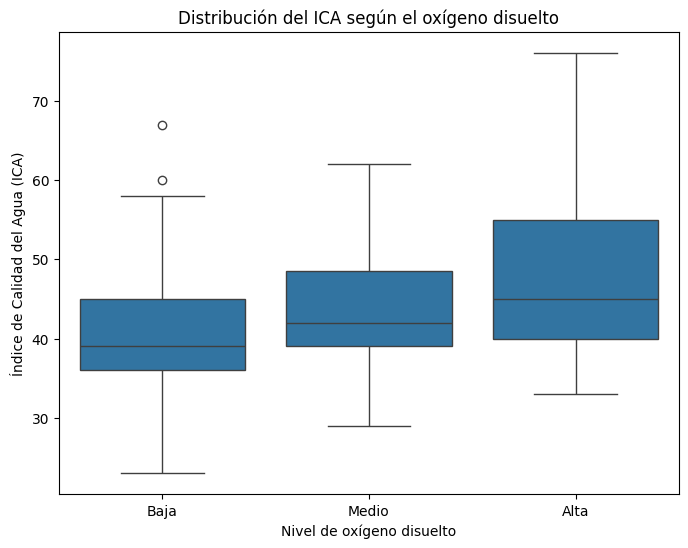

In [104]:
grupo1['od'] = 'Baja'
grupo2['od'] = 'Medio'
grupo3['od'] = 'Alta'

# Concatenar los dos grupos en un solo DataFrame para facilitar el graficado
df_concentracion = pd.concat([grupo1, grupo2,grupo3])

# Crear el boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_concentracion, x='od', y='ica')
plt.title('Distribución del ICA según el oxígeno disuelto')
plt.xlabel('Nivel de oxígeno disuelto')
plt.ylabel('Índice de Calidad del Agua (ICA)')
plt.show()

In [105]:
# Separar la variable objetivo (MedHouseVal) de las variables predictoras
#x = aguadataframe.select_dtypes(include='number')
#X = x.drop('ica', axis=1)

X = aguadataframe[['p_total_l_mg_l','colif_fecales_ufc_100ml','od','turbiedad_ntu']]

y = aguadataframe['ica']

# Estandarizar las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Metamoslo en un dataframe así no perdemos los nombres de las columnas
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

In [106]:
import statsmodels.api as sm
# Agregamos una constante como característica, para estimar la ordenada al origen
X_scaled_df_ = sm.add_constant(X_scaled_df)
# Ajustamos el modelo
model = sm.OLS(y, X_scaled_df_).fit()
# Imprimimos el resumen de los resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ica   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     6.133
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           0.000135
Time:                        12:12:40   Log-Likelihood:                -543.77
No. Observations:                 154   AIC:                             1098.
Df Residuals:                     149   BIC:                             1113.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [107]:
_, p = shapiro(model.resid)
print("p = %.4f" % (p))

p = 0.0000


In [108]:
from sklearn.model_selection import train_test_split

y = aguadataframe['ica']
x = aguadataframe.drop('ica', axis=1)
X = x.select_dtypes(include=['number'])

y_binned = pd.cut(y, bins=4, labels=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y_binned)

y_train_binned = pd.cut(y_train, bins=4, labels=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.1,
                                                  random_state=10, # usamos una semilla aleatoria para ser reproducibles
                                                  stratify = y_train_binned)


print("DESPUÉS de sacar los datos de validación:")
print("Entrenamiento = {}".format(X_train.shape))
print("Validación = {}".format(X_val.shape))
print("Test = {}".format(X_test.shape))
print("---------------------------------------")


DESPUÉS de sacar los datos de validación:
Entrenamiento = (96, 17)
Validación = (11, 17)
Test = (47, 17)
---------------------------------------


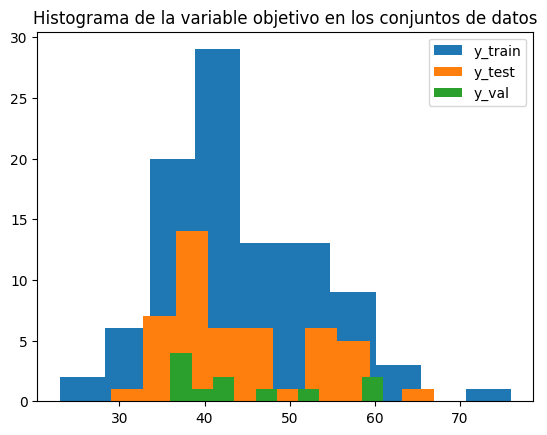

In [109]:
plt.hist(y_train, bins=10, label='y_train')
plt.hist(y_test, bins=10, label='y_test')
plt.hist(y_val, bins=10, label='y_val')
plt.legend(loc='upper right')
plt.title('Histograma de la variable objetivo en los conjuntos de datos')
plt.show()

In [110]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_stand = scaler.transform(X_train)

In [111]:
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.linear_model import Lasso

# Configuración inicial
mae_list_lasso = []
alpha_list = []
alpha = 0

# Escalamos los datos de validación
X_val_stand = scaler.transform(X_val)  # Usamos transform, no fit_transform, si scaler ya está ajustado

# Iteramos sobre los valores de alpha
while alpha < 5:
    # Creamos un modelo de Lasso con el valor actual de alpha
    lasso_model = Lasso(alpha=alpha)
    lasso_model.standardizer_ = scaler

    # Entrenamos el modelo
    lasso_model.fit(X_train_stand, y_train)

    # Predecimos en el conjunto de validación
    y_pred_val_lasso = lasso_model.predict(X_val_stand)

    # Calculamos el MAE y lo guardamos junto al valor de alpha
    mae_val_lasso = mean_absolute_error(y_val, y_pred_val_lasso)
    mae_list_lasso.append(mae_val_lasso)
    alpha_list.append(alpha)  # Agregamos el alpha actual a la lista

    # Incrementamos el valor de alpha
    alpha += 0.01

# Encontrar el alpha que minimiza el MAE
best_alpha_index = np.argmin(mae_list_lasso)
best_alpha_lasso = alpha_list[best_alpha_index]
print("El mejor alpha para Lasso es:", best_alpha_lasso)
print("El MAE es: ",min(mae_list_lasso))


c:\Users\court\OneDrive\Documentos\FundamentosDatos\TPE\PracticoEspecialGrupo14\.venv\Lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\court\OneDrive\Documentos\FundamentosDatos\TPE\PracticoEspecialGrupo14\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\court\OneDrive\Documentos\FundamentosDatos\TPE\PracticoEspecialGrupo14\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e+03, tolerance: 7.903e-01 Linear regression models with null

El mejor alpha para Lasso es: 0.13999999999999999
El MAE es:  6.228648476161817


In [112]:
lasso = Lasso(alpha=best_alpha_lasso)
lasso.fit(X_train_stand, y_train)

Lasso(alpha=0.13999999999999999)

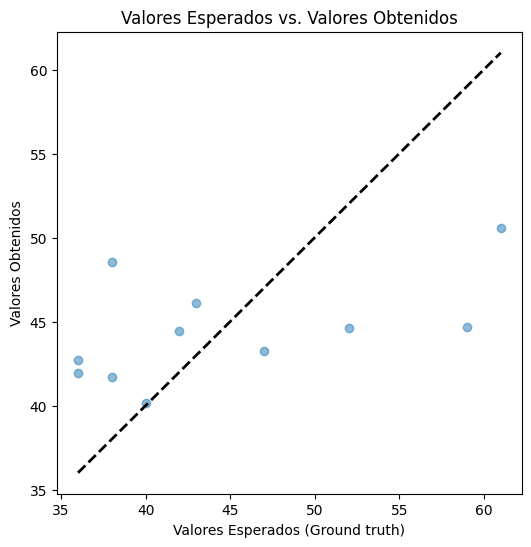

In [113]:
y_pred_val = lasso.predict(X_val_stand)

plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.xlabel("Valores Esperados (Ground truth)")
plt.ylabel("Valores Obtenidos")

plt.title("Valores Esperados vs. Valores Obtenidos")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.show()

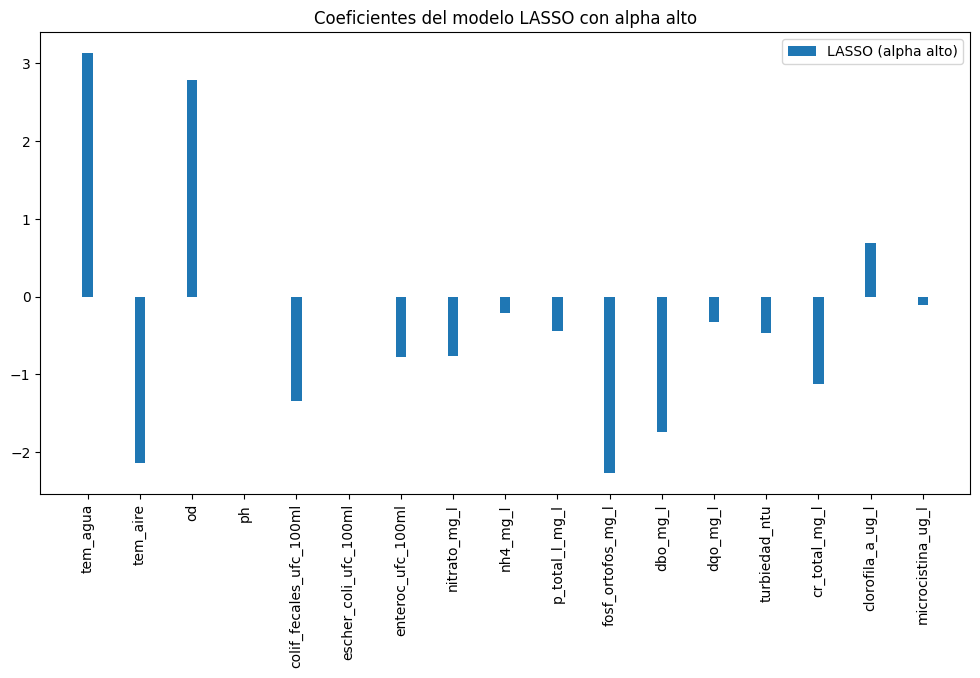

In [114]:
theta_lasso = lasso.coef_

labels = X.columns  # Asumiendo que X es un dataframe de pandas

# Creamos el gráfico
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(np.arange(len(theta_lasso)), theta_lasso, width=0.2, label='LASSO (alpha alto)')
ax.set_xticks(np.arange(len(theta_lasso)))
ax.set_xticklabels(labels, rotation=90)
ax.legend()
ax.set_title('Coeficientes del modelo LASSO con alpha alto')
plt.show()

In [115]:
X_test_stand = scaler.transform(X_test)
y_pred_test_lasso = lasso.predict(X_test_stand)

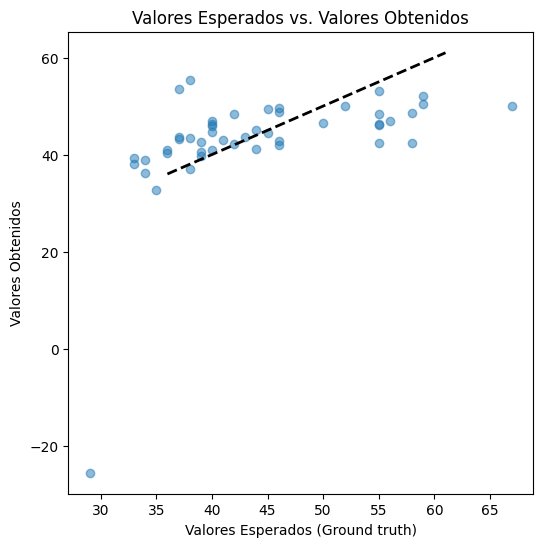

In [116]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test_lasso, alpha=0.5)
plt.xlabel("Valores Esperados (Ground truth)")
plt.ylabel("Valores Obtenidos")

plt.title("Valores Esperados vs. Valores Obtenidos")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.show()

In [117]:
mae_test_lasso = mean_absolute_error(y_test, y_pred_test_lasso)
print("Lasso : {:.5f}".format(mae_test_lasso))

Lasso : 6.60935


PREGUNTAR LASSO